In [5]:
import os
import pickle
import numpy as np
from random import shuffle
from IPython.display import Image

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from utils import *
from qs_vae import *
from utils_features import *

## Content  
In this notebook we train a ConvNet on 50 random splittings of the dataset. These splits are done observationally to protect against overfitting. Each split randomly assigns 5 AR and 5 PF observations to the test set. Since each observation has a different number of spectra, we ensure AR/PF class balance in both test and training sets by under sampling the majority class. We also enforce a 60:40 split for the final train and test sets.  

During the training of each split we save the ***model*** that achieves the lowest validation loss, as well as several items within a dictionary:     
- ***train_obs*** $\to$ The list of observations in the training set  
- ***test_obs*** $\to$ The list of observations in the test set  
- ***n_train*** $\to$ The number of spectra within the training set  
- ***n_test*** $\to$ The number of spectra within the test set  
- ***epoch*** $\to$ The epoch out of 20 that scored the lowest validation loss  
- ***TSS*** $\to$ The best models true skill statistic  
- ***ACC*** $\to$ The best models accuracy  
- ***train_loss_list*** $\to$ The learning curve for the training dataset  
- ***validation_loss_list*** $\to$ The learning curve for the test dataset  

It might be the case that similar PF signatures do not occur in all PF observations, therefore, the split is not only necessary to derive average statistics and variances of the models performance, but it is also useful to isolate a common mechanism that might not be present in all observations. The model from the split that resulted in the highest TSS will then be used for the calculation of attributions via both the Grad-CAM and Expected Gradients formalism. Note that before selecting the best model and observational split, the number of spectra from both test and training sets should be evaluated. If the TSS is high but either of the sets have very few spectra, then one should rather opt for a lower TSS with a more rigorous statistical sample. In-other-words, the optimal split is one that is statistically robust and has a high performance.  

### ConvNet architecture

In [2]:
class CNN(nn.Module):
    '''
    ConvNet architecture for Grad-CAM application (see figure)
    '''
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.num_classes = num_classes
        
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=20, stride=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=10, stride=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=44, out_features=5),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=self.num_classes)
        )
        
    def forward(self,x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.linear_layers(x)

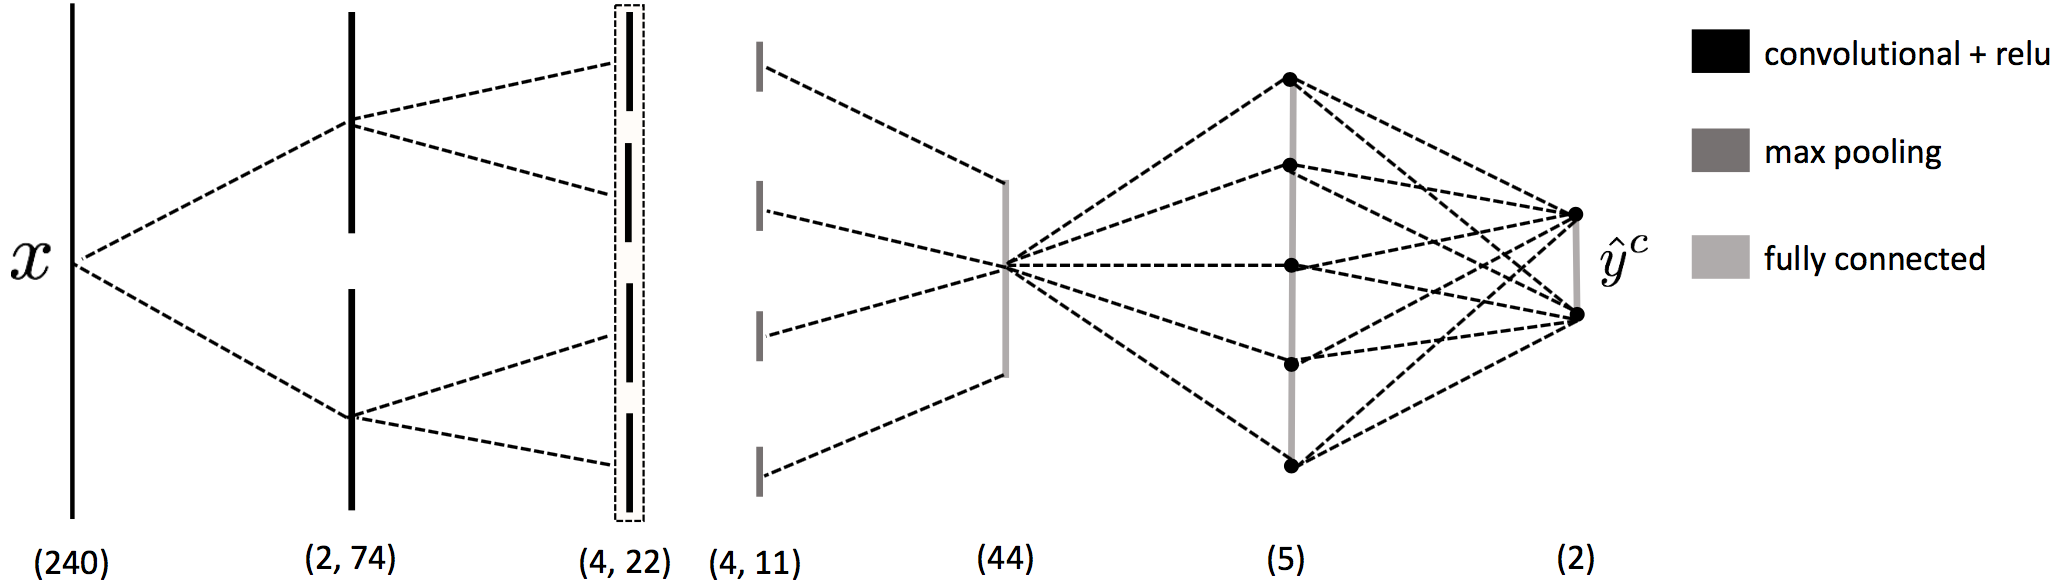

In [4]:
Image(filename='ConvNet.png') 

### Code for cleaning the data  
Each observation is cleaned using the functions below and then saved separately in a numpy save file. Spectra are removed if they meet one or more of the following criteria: 
1. If a spectrum contains one or more nan values (missing data)
2. If the pseudo continuum between 2799.7-2800.2 is more or equal to 40 % the maximum profile value (limb obs)   
3. If the maximum value falls outside a small window around both cores (cosmic rays, window of 10-data points)  
4. If the reconstruction error from the QS VAE is to low (we used the strong criteria)

Note that these cleaning steps are in addition to the steps used to produce the IRISreader lvl2C data. 

In [3]:
path_to_data = "/data1/iris_level_2C_10DNs/"
obs = os.listdir(path_to_data)
PF_obs = [ob for ob in obs if 'PF' in ob]
AR_obs = [ob for ob in obs if 'AR' in ob]

In [6]:
encoder = Encoder()
decoder = Decoder()
model = VAE(encoder, decoder).to(device)
model.load_state_dict(torch.load('/data1/userspace/bpanos/multiline/vae/qs_vae_MgII.pt'))
model.eval();

In [7]:
def vae_label(nprof, thresholds=[.5,3,5] ):
    '''
    take profiles [m, lambda] and turn into vector of mean square errors
    from their reconstructed profiles. Then group each profiles reconstruction
    error with the provided thresholds
    '''
    # Make data compatible with pytorch
    nprof = torch.Tensor( nprof )
    nprof = nprof.view(-1, 1, 240)
    nprof = nprof.to(device, dtype= torch.float)
    
    # pass to vae 
    generated, z_mu, z_var = model(nprof)
    
    # turn torch tensors to numpy arrays 
    generated = torch_to_numpy(generated)
    real = torch_to_numpy(nprof)
    
    # calculate mse error for every nprof
    mse = mse_loss( real, generated )
    
    # label
    thresholds=np.array(thresholds).reshape(len(thresholds),1)
    dist_mat = np.abs(thresholds - mse)
    labels = np.argmin(dist_mat, axis=0)
    return labels, mse

In [8]:
def process_obs(obs_name):
    '''
    This function rejects spectra if one or more of the following conditions are met:
    1) If a spectrum contains one or more nan values (missing data)
    2) If the psudocontinium between 2799.7-2800.2 is more or equal to 40 % the maximum profile value (limb obs) 
    3) If the maximum value falls outside a small window around both cores (cosmic rays, window of 10-data points)
    4) If the reconstruction error from the QS VAE is to low
    '''
    # load lvl2C data and reshape into (i, wavelength)
    fhand = np.load(path_to_data + obs_name, allow_pickle=True)
    data = fhand['data']
    nprof = profile_rep(data)
    
    # 1) delete spectra with any nan values
    nprof = nprof[~np.isnan(nprof).any(axis=1)]
    
    # 2) delete spectra with extreamly high psudocontinium probably from limb obs
    low_continuum = np.squeeze(np.argwhere(np.mean(nprof[:,115:125], axis=1) < .4))
    nprof = nprof[low_continuum]
    
    # 3) clean cosmic rays
    clean_prof = []
    for prof in nprof:
        max_ind = np.squeeze(np.argmax(prof))
        if max_ind in np.arange(kl,kr+1,1) or max_ind in np.arange(hl,hr+1,1):
                             clean_prof.append(prof)
    nprof = np.vstack(clean_prof)
    
    # 4) delete qs spectra using vae (strong condition labels==2)
    labels, mse = vae_label(nprof)
    active_inds = np.squeeze( np.argwhere( labels == 2 ) )
    nprof = nprof[active_inds, :]

    return nprof

In [12]:
# save_path = '/data1/userspace/bpanos/XAI/data/ConvNet/clean_strong/'
# for AR in AR_obs:
#     X = process_obs(AR)
#     np.savez(f'{save_path}{AR}', X=X)
# for PF in PF_obs:
#     X = process_obs(PF)
#     np.savez(f'{save_path}{PF}', X=X)

In [9]:
path_to_clean_data = '/data1/userspace/bpanos/XAI/data/ConvNet/clean_strong/'

#### This code block contains functions important for the training and evaluation of the models  

In [5]:
def train():
    '''
    training loop for the model
    output --> average loss on the training dataset after each epoch  
    '''
    model.train()
    train_loss = []
    for x, y in train_dataloader:
        x = x.view(-1, 1, x.shape[-1]).to(device)
        y = y.long().to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = np.array(train_loss)
    train_loss = np.mean(train_loss)
        
    return train_loss

def test():
    '''
    Test loop for the model
    output --> average loss on the test dataset after each epoch  
    '''
    model.eval()
    val_loss = []
    for x, y in test_dataloader:
        x = x.view(-1, 1, x.shape[-1]).to(device)
        y = y.long().to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        val_loss.append(loss.item())
    val_loss = np.array(val_loss)
    val_loss = np.mean(val_loss)
        
    return val_loss

def calculate_metrics(loader, model):
    '''
    Calculates the true skill statistic and accuracy 
    '''
    num_correct = 0
    num_samples = 0
    matrix = np.zeros((2,2))
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.view(-1, 1, x.shape[-1]).to(device)
            y = y.long().to(device)
            y_hat = model(x)
            _, predicted_class = y_hat.max(dim=1)
            num_correct += (predicted_class == y).sum()
            num_samples += predicted_class.size(0)
            acc = np.round(float(num_correct)/float(num_samples)*100,2)
            matrix += confusion_matrix(y.cpu(), predicted_class.cpu())
    TP = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TN = matrix[1,1]
    TSS = np.round(TP/(TP+FN) - FP/(FP+TN),2)
    return TSS, acc

def Balance(X1, X2):
    '''
    Takes in two numpy arrays and under samples the larger array to have a 1:1 ratio
    '''
    if len(X1) < len(X2):
        rand_int = np.random.choice(len(X2), len(X1), replace=False)
        X2 = X2[rand_int, :]
    if len(X2) < len(X1):
        rand_int = np.random.choice(len(X1), len(X2), replace=False)
        X1 = X1[rand_int, :]
    return X1, X2

class ConvNetDataSet(Dataset):
    '''
    DataLoader
    '''
    def __init__(self, partition='train'):
        fhand = np.load(f'/data1/userspace/bpanos/XAI/data/ConvNet/{partition}.npz')
        self.X = torch.Tensor(fhand['X'])
        self.y = torch.Tensor(fhand['y'])
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):
        return self.X[index,:], self.y[index]

#### This code block generates 50 random observational splittings and trains a model for each over 20 epochs  
The best model per split is saved as well as a few performance metrics and obs lists

In [3]:
'''
Collect IDs for all observations
'''
files = os.listdir(path_to_clean_data)
AR_file_ids = []
PF_file_ids = []
for filename in files:
    if 'AR' in filename:
        AR_file_ids.append(filename)
    if 'PF' in filename:
        PF_file_ids.append(filename)
        
for itter in range(50):
    '''
    Randomly split train and validation ids 
    '''
    AR_train, AR_test = train_test_split(AR_file_ids, test_size=5, random_state=itter)
    PF_train, PF_test = train_test_split(PF_file_ids, test_size=5, random_state=itter)
    
    '''
    Label data and create train set
    '''
    #-------------------------Train set-------------------------
    X_train_AR = None
    X_train_PF = None
    for AR_file, PF_file in zip(AR_train, PF_train):

        fhand = np.load(path_to_clean_data + AR_file)
        X_AR = fhand['X']
        try: X_train_AR = np.concatenate( (X_train_AR, X_AR), axis=0 )
        except: X_train_AR = X_AR

        fhand = np.load(path_to_clean_data + PF_file)
        X_PF = fhand['X']
        try: X_train_PF = np.concatenate( (X_train_PF, X_PF), axis=0 )
        except: X_train_PF = X_PF
            
    X_train_AR, X_train_PF = Balance(X_train_AR, X_train_PF)
    y_train_AR = np.zeros(len(X_train_AR))
    y_train_PF = np.ones(len(X_train_PF))
    
    X_train = np.concatenate((X_train_AR, X_train_PF), axis=0)
    y_train = np.concatenate((y_train_AR, y_train_PF))
    
    '''
    Label data and create test set (with additional under sampling for a 60:40 ratio) 
    '''
    #-------------------------Test set-------------------------
    X_test_AR = None
    X_test_PF = None
    for AR_file, PF_file in zip(AR_test, PF_test):

        fhand = np.load(path_to_clean_data + AR_file)
        X_AR = fhand['X']
        try: X_test_AR = np.concatenate( (X_test_AR, X_AR), axis=0 )
        except: X_test_AR = X_AR

        fhand = np.load(path_to_clean_data + PF_file)
        X_PF = fhand['X']
        try: X_test_PF = np.concatenate( (X_test_PF, X_PF), axis=0 )
        except: X_test_PF = X_PF
            
    X_test_AR, X_test_PF = Balance(X_test_AR, X_test_PF)
    y_test_AR = np.zeros(len(X_test_AR))
    y_test_PF = np.ones(len(X_test_PF))
    
    X_test = np.concatenate((X_test_AR, X_test_PF), axis=0)
    y_test = np.concatenate((y_test_AR, y_test_PF))
    
    # undersample test set to 40 percent
    n_test = int(len(X_train) * 0.4)
    try:
        rand_ind = np.random.choice(len(X_test)-3, n_test, replace=False)
        X_test = X_test[rand_ind,:]
        y_test = y_test[rand_ind]
    except Exception: pass
    
    np.savez('/data1/userspace/bpanos/XAI/data/ConvNet/train', X=X_train, y=y_train)
    np.savez('/data1/userspace/bpanos/XAI/data/ConvNet/test', X=X_test, y=y_test)
    
    '''
    Train ConvNet over 20 epochs
    '''
    n_epoch = 20
    model = CNN(num_classes=2).to(device)
    learning_rate = 0.001
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    batch_size = 64
    train_dataset = ConvNetDataSet(partition='train')
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_dataset = ConvNetDataSet(partition='test')
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    save_path_models = '/data1/userspace/bpanos/XAI/models/ConvNet/'
    train_loss_list = []
    validation_loss_list = []
    best_val_loss = 1e9
    
    for epoch in range(n_epoch):
        train_loss_list.append( train() )
        current_val_loss = test()
        validation_loss_list.append(current_val_loss)
        
        if current_val_loss < best_val_loss:
            torch.save(model.state_dict(), f'{save_path_models}{itter}.pt')
            best_val_loss = current_val_loss
            best_epoch = epoch
            
    model = CNN(num_classes=2)
    model.load_state_dict(torch.load(f'{save_path_models}{itter}.pt'))
    model.to(device)
    model.eval();
    
    TSS, ACC = calculate_metrics(test_dataloader, model)
    print(f'TSS: {TSS} ACC: {ACC}')
    
    stats = {'train_obs': AR_train + PF_train,
             'test_obs': AR_test + PF_test,
             'n_train': len(X_train),
             'n_test': len(X_test),
             'epoch': best_epoch,
             'TSS': TSS,
             'ACC': ACC,
             'validation_loss_list': validation_loss_list,
             'train_loss_list': train_loss_list}
    
    with open(f'{save_path_models}{itter}.p', 'wb') as f: pickle.dump(stats,f)

    del model, train_dataloader, train_dataset, test_dataloader, test_dataset

### Collect statistics

In [4]:
keys = ['train_obs', 
        'test_obs',
        'n_train',
        'n_test',
        'epoch',
        'TSS',
        'ACC',
        'validation_loss_list',
        'train_loss_list']

In [5]:
save_path_models = '/data1/userspace/bpanos/XAI/models/ConvNet/'
train_obs_list = []
test_obs_list = []
n_train_list = []
n_test_list = []
epoch_list = []
TSS_list = []
ACC_list = []
validation_loss_listList = []
train_loss_list_list = []
train_test_ratio_list = []
for itter in range(50):
    with open(f'{save_path_models}{itter}.p', 'rb') as f: stats = pickle.load(f)
    if np.isnan(stats['TSS']): continue
    train_obs_list.append(stats['train_obs'])
    test_obs_list.append(stats['test_obs'])
    n_train_list.append(stats['n_train'])
    n_test_list.append(stats['n_test'])
    epoch_list.append(stats['epoch'])
    TSS_list.append(stats['TSS'])
    ACC_list.append(stats['ACC'])
    validation_loss_listList.append(stats['validation_loss_list'])
    train_loss_list_list.append(stats['train_loss_list'])
    train_test_ratio_list.append(np.round(stats['n_test']/stats['n_train'], 2))

In [6]:
all_stats_dic = {}
for itter in range(50):
    all_stats_list = []
    with open(f'{save_path_models}{itter}.p', 'rb') as f: stats = pickle.load(f)
    for key in keys:
        all_stats_list.append(stats[key])
    all_stats_dic[str(itter)] = all_stats_list

In [7]:
sorted_itters = sorted(all_stats_dic.keys(), key = lambda x: all_stats_dic[x][5], reverse = True)

In [9]:
for mod in sorted_itters:
    out = f'''
    model: {mod}
    TSS: {all_stats_dic[mod][5]}
    ACC: {all_stats_dic[mod][6]}
    epoch: {all_stats_dic[mod][4]}
    Test/Train-ratio: {np.round(all_stats_dic[mod][3]/all_stats_dic[mod][2], 2)}
    # train spec: {np.int(all_stats_dic[mod][2])}
    # test spec: {np.int(all_stats_dic[mod][3])}
    '''
    print(out)
    print('-'*30)

### Plot statistics

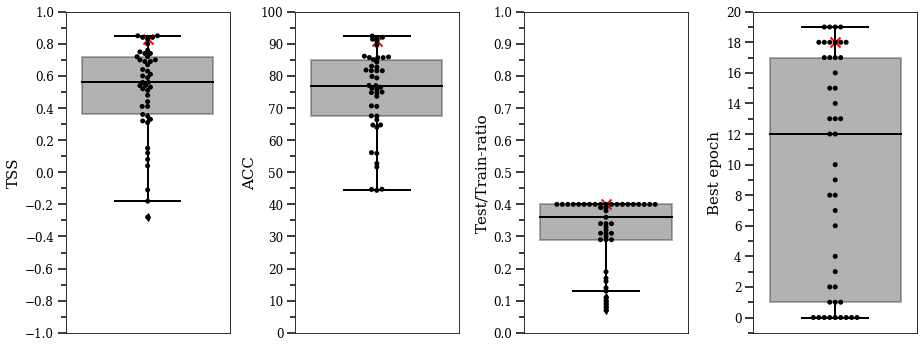

In [121]:
fig = plt.figure(figsize=(13,5), constrained_layout=False)
rcParams['font.size'] = 12
rcParams['font.family'] = 'serif'
plt.rcParams['lines.linewidth'] = 2
gs = fig.add_gridspec(1, 4)

ax = fig.add_subplot(gs[0, 0])
plt.ylabel('TSS', fontsize=15)
sns.boxplot( data=TSS_list, color="k", boxprops=dict(alpha=.3))
sns.swarmplot(data=TSS_list, color="k")
plt.scatter(0, TSS_list[40], c='r', s=100, marker='x')
ax.set_xticks([])
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
ax.tick_params(which='major', length=8,width=1.5) 
ax.tick_params(which='minor', length=5,width=1.5)
plt.ylim(-1,1)

ax = fig.add_subplot(gs[0, 1])
plt.ylabel('ACC', fontsize=15)
sns.boxplot( data=ACC_list, color="k", boxprops=dict(alpha=.3))
sns.swarmplot(data=ACC_list, color="k")
plt.scatter(0, ACC_list[40], c='r', s=100, marker='x')
ax.set_xticks([])
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(which='major', length=8,width=1.5) 
ax.tick_params(which='minor', length=5,width=1.5)
plt.ylim(0,100)

ax = fig.add_subplot(gs[0, 2])
plt.ylabel('Test/Train-ratio', fontsize=15)
sns.boxplot( data=train_test_ratio_list, color="k", boxprops=dict(alpha=.3))
sns.swarmplot(data=train_test_ratio_list, color="k")
plt.scatter(0, train_test_ratio_list[40], c='r', s=100, marker='x')
ax.set_xticks([])
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(which='major', length=8,width=1.5) 
ax.tick_params(which='minor', length=5,width=1.5)
plt.ylim(0,1)

ax = fig.add_subplot(gs[0, 3])
plt.ylabel('Best epoch', fontsize=15)
sns.boxplot( data=epoch_list, color="k", boxprops=dict(alpha=.3))
sns.swarmplot(data=epoch_list, color="k")
plt.scatter(0, epoch_list[40], c='r', s=100, marker='x')
ax.set_xticks([])
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='major', length=8,width=1.5)
ax.tick_params(which='minor', length=5,width=1.5)
labels = [item.get_text() for item in ax.get_yticklabels()]
plt.ylim(-1,20)

plt.tight_layout()
# plt.savefig('/data1/userspace/bpanos/XAI/figs/ConvNet_stats2.pdf')
plt.show()

### Best split  
The best split is from iteration 44, corresponding to the save model 44.pt. This splits statistics are indicated by the red cross in the above plot. 

In [18]:
mod = '44'
out = f'''
model: {mod}
TSS: {all_stats_dic[mod][5]}
ACC: {all_stats_dic[mod][6]}
epoch: {all_stats_dic[mod][4]}
Test/Train-ratio: {np.round(all_stats_dic[mod][3]/all_stats_dic[mod][2], 2)}
# train spec: {np.int(all_stats_dic[mod][2])}
# test spec:  {np.int(all_stats_dic[mod][3])}
'''
print(out)
print('Obs in train set')
print('-'*40)
for obs_train in all_stats_dic[mod][0]:
    print(obs_train)
print('Obs in test set')
print('-'*40)
for obs_test in all_stats_dic[mod][1]:
    print(obs_test)


model: 44
TSS: 0.83
ACC: 90.83
epoch: 18
Test/Train-ratio: 0.4
# train spec: 48386
# test spec:  19354

Obs in train set
----------------------------------------
AR_20150704_100921_3860108354.npz
AR_20150809_061551_3860009180.npz
AR_20150518_161415_3860256971.npz
AR_20140329_201426_3820011652.npz
AR_20150521_185917_3800507454.npz
AR_20141201_154438_3800008053.npz
AR_20151017_003115_3660105403.npz
AR_20150130_112715_3860607366.npz
AR_20150728_151849_3660109122.npz
AR_20150704_165917_3620006130.npz
AR_20140313_093521_3820109554.npz
AR_20150724_053523_3620109103.npz
AR_20150518_143915_3860256971.npz
PF_20140212_215458_3860257280.npz
PF_20150312_054519_3860107053.npz
PF_20141022_081850_3860261381.npz
PF_20150821_160115_3660104044.npz
PF_20141107_093726_3860602088.npz
PF_20140611_181927_3863605329.npz
PF_20140910_112825_3860259453.npz
PF_20140329_140938_3860258481.npz
PF_20140612_110933_3863605329.npz
PF_20140906_112339_3820259253.npz
PF_20141025_145828_3880106953.npz
PF_20150311_044603_38

In [1]:
# mod = '20'
# out = f'''
# model: {mod}
# TSS: {all_stats_dic[mod][5]}
# ACC: {all_stats_dic[mod][6]}
# epoch: {all_stats_dic[mod][4]}
# Test/Train-ratio: {np.round(all_stats_dic[mod][3]/all_stats_dic[mod][2], 2)}
# # train spec: {np.int(all_stats_dic[mod][2])}
# # test spec:  {np.int(all_stats_dic[mod][3])}
# '''
# print(out)
# print('Obs in train set')
# print('-'*40)
# for obs_train in all_stats_dic[mod][0]:
#     print(obs_train)
# print('Obs in test set')
# print('-'*40)
# for obs_test in all_stats_dic[mod][1]:
#     print(obs_test)

Jonas: 20150130_112715_3860607366 leads to a flare 30 mins after IRIS obs  
20150809_061551_3860009180 has a C-class flare in the midle (Just GOES?)

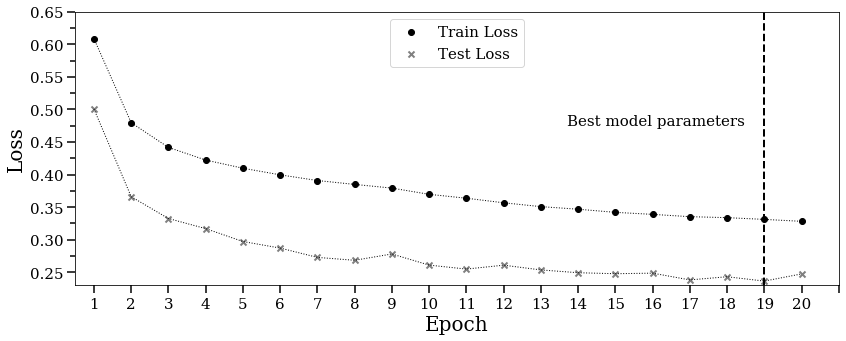

In [29]:
fig, ax = plt.subplots(figsize=(12,5))
rcParams['font.size'] = 15
rcParams['font.family'] = 'serif'
plt.rcParams['lines.linewidth'] = 2
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.text(0.76, 0.6, 'Best model parameters', horizontalalignment='center',
                        verticalalignment='center', transform=ax.transAxes)

train_loss = all_stats_dic[mod][8]
test_loss = all_stats_dic[mod][7]
plt.scatter(range(len(train_loss)), train_loss, c='k', label='Train Loss')
plt.plot(train_loss, c='k', linewidth=1, linestyle=':')
plt.scatter(range(len(test_loss)), test_loss, c='grey', label='Test Loss', marker='x')
plt.plot(test_loss, c='k', linewidth=1, linestyle=':')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.025))
ax.tick_params(which='major', length=8,width=1.5) 
ax.tick_params(which='minor', length=5,width=1.5)
plt.ylim(0.23,0.65)
plt.xlim(-0.5,20)
plt.axvline(18, linestyle='--', c='k')
ax.legend(loc='upper center')

labels = [item.get_text() for item in ax.get_xticklabels()]
ll = np.arange(1, 21)
for l in ll:
    labels[l] = l
ax.set_xticklabels(labels)

plt.tight_layout()
# plt.savefig('/data1/userspace/bpanos/XAI/figs/ConvNet_learning_curve_w.pdf')
plt.show()